# **GNR-652 Course Project**
## **American Sign Language (ASL) Detection**
### June 10, 2020
### Submitted by:
* ### Samyak Shah (18D070062)
* ### Aseer Israr Ansari (18D070040)
* ### Ritwik Khandelwal (18D070061)
* ### Ayush Dahale (18D070041)

## **Introduction and the dataset**
The ASL Alphabet data set provides 87,000 images of the ASL alphabet. This project aims to build a model around this dataset that is robust enough to handle images of the ASL alphabet with different hands, sizes and backgrounds. Our project is an effort to make life easier for the destitutes of vision and speech. 

The dataset used in this project is [ASL Alphabet](http://) dataset from Kaggle. The notebook was prepared on Kaggle kernel, so, there may be a few changes (mainly in the data input) in the code if run on some other platforms.
The asl_alphabet_train subfolder contains 87,000 images. We plan to use images from this folder for training, cross validation and testing. The asl_alphabet_test subfolder contains only 28 images, so we will use this data for aiding the visualization of the model.

Note: The training folder contains 29 subfolders, 26 for each alphabet, one each for space, delete and blank images.

## Importing essential libraries

In [1]:
import numpy as np
import pandas as pd
import os
import keras
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
print(os.listdir("../input/asl-alphabet"))

Using TensorFlow backend.


['asl_alphabet_test', 'asl_alphabet_train']


### Assigning subdirectory paths

In [2]:
train_dir = '../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
test_dir = '../input/asl-alphabet/asl_alphabet_test/asl_alphabet_test'

### Plotting one image from each class for observing the data.

unique_labels =  ['N', 'R', 'A', 'U', 'J', 'Y', 'M', 'nothing', 'L', 'K', 'G', 'E', 'O', 'C', 'P', 'F', 'space', 'Z', 'I', 'D', 'del', 'B', 'T', 'W', 'Q', 'V', 'H', 'X', 'S']


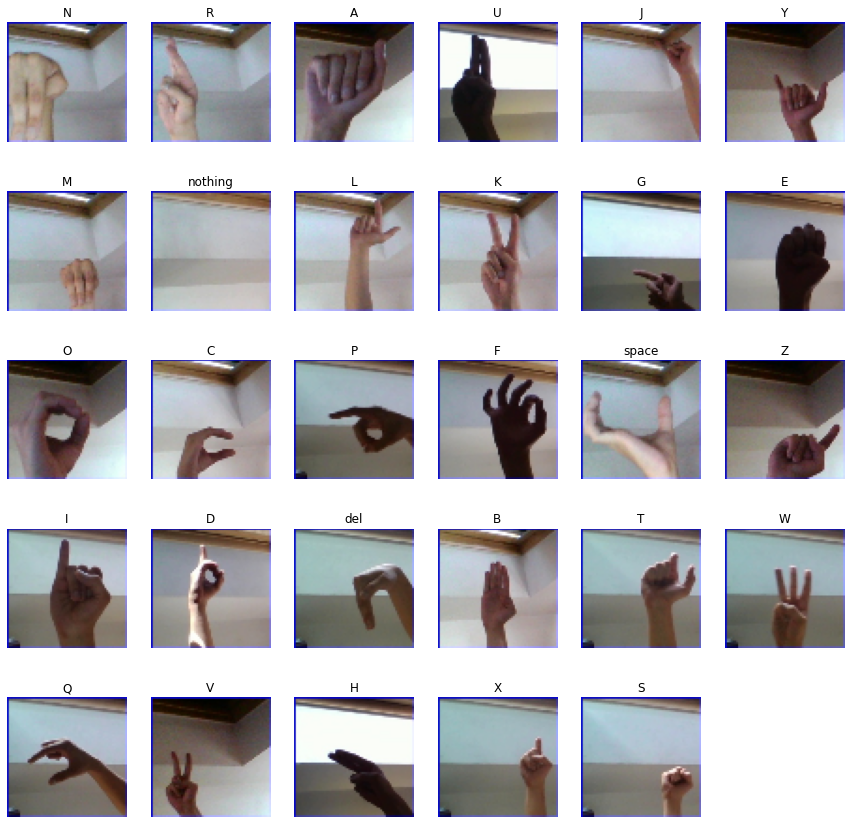

In [3]:
def load_unique():
    size_img = 64,64 
    images_for_plot = []
    labels_for_plot = []
    for folder in os.listdir(train_dir):
        for file in os.listdir(train_dir + '/' + folder):
            filepath = train_dir + '/' + folder + '/' + file
            image = cv2.imread(filepath)
            final_img = cv2.resize(image, size_img)
            final_img = cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)
            images_for_plot.append(final_img)
            labels_for_plot.append(folder)
            break
    return images_for_plot, labels_for_plot

images_for_plot, labels_for_plot = load_unique()
print("unique_labels = ", labels_for_plot)

fig = plt.figure(figsize = (15,15))
def plot_images(fig, image, label, row, col, index):
    fig.add_subplot(row, col, index)
    plt.axis('off')
    plt.imshow(image)
    plt.title(label)
    return

image_index = 0
row = 5
col = 6
for i in range(1,(row*col)):
    plot_images(fig, images_for_plot[image_index], labels_for_plot[image_index], row, col, i)
    image_index = image_index + 1
plt.show()

### Loading Data

1. Defining a dictionary which contains labels and its mapping to the class labels.
2. Loading the image data and labels and then mapping those labels according to the dictionary defined above.
3. Normalizing image data.
4. One-hot encoding of the labels
5. Splitting the data into training and test data (95% training, 5% test). The training data is further subdivided into for training and cross-validation.

In [4]:
labels_dict = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,
                   'N':13,'O':14,'P':15,'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,
                   'Z':25,'space':26,'del':27,'nothing':28}

def load_data():
    """
    Loads data and preprocess. Returns train and test data along with labels.
    """
    images = []
    labels = []
    size = 64,64
    print("LOADING DATA FROM : ",end = "")
    for folder in os.listdir(train_dir):
        print(folder, end = ' | ')
        for image in os.listdir(train_dir + "/" + folder):
            temp_img = cv2.imread(train_dir + '/' + folder + '/' + image)
            temp_img = cv2.resize(temp_img, size)
            images.append(temp_img)
            labels.append(labels_dict[folder])
    
    images = np.array(images)
    images = images.astype('float32')/255.0
    
    labels = keras.utils.to_categorical(labels)
    
    X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size = 0.05)
    
    print('Loaded', len(X_train),'images for training,','Train data shape =',X_train.shape)
    print('Loaded', len(X_test),'images for testing','Test data shape =',X_test.shape)
    
    return X_train, X_test, Y_train, Y_test

## Defining the model.

In [5]:
def create_model():
    
    model = Sequential()
    
    model.add(Conv2D(16, kernel_size = [3,3], padding = 'same', activation = 'relu', input_shape = (64,64,3)))
    model.add(Conv2D(32, kernel_size = [3,3], padding = 'same', activation = 'relu'))
    model.add(MaxPool2D(pool_size = [3,3]))
    
    model.add(Conv2D(32, kernel_size = [3,3], padding = 'same', activation = 'relu'))
    model.add(Conv2D(64, kernel_size = [3,3], padding = 'same', activation = 'relu'))
    model.add(MaxPool2D(pool_size = [3,3]))
    
    model.add(Conv2D(128, kernel_size = [3,3], padding = 'same', activation = 'relu'))
    model.add(Conv2D(256, kernel_size = [3,3], padding = 'same', activation = 'relu'))
    model.add(MaxPool2D(pool_size = [3,3]))
    
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(512, activation = 'relu', kernel_regularizer = regularizers.l2(0.001)))
    model.add(Dense(29, activation = 'softmax'))
    
    model.compile(optimizer = 'adam', loss = keras.losses.categorical_crossentropy, metrics = ["accuracy"])
    
    print("MODEL CREATED")
    model.summary()
    
    return model

def fit_model(X_train,Y_train):
    model_hist = model.fit(X_train, Y_train, batch_size = 64, epochs = 5, validation_split = 0.1)
    return model_hist 

### Compiling the model and fitting the training data.
#### Note: 10% of the training data is used for cross-validation.

In [6]:
X_train, X_test, Y_train, Y_test=load_data()
model = create_model()
curr_model_hist = fit_model(X_train,Y_train)

LOADING DATA FROM : N | R | A | U | J | Y | M | nothing | L | K | G | E | O | C | P | F | space | Z | I | D | del | B | T | W | Q | V | H | X | S | Loaded 82650 images for training, Train data shape = (82650, 64, 64, 3)
Loaded 4350 images for testing Test data shape = (4350, 64, 64, 3)
MODEL CREATED
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 16)        448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)

### Plotting the model performance metrics

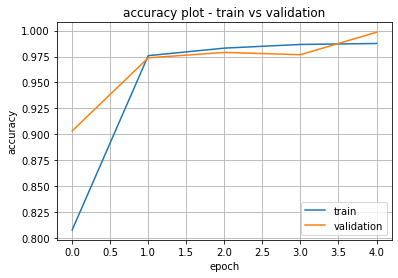

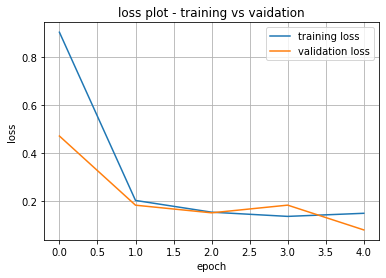

In [14]:
plt.plot(curr_model_hist.history['accuracy'])
plt.plot(curr_model_hist.history['val_accuracy'])
plt.legend(['train', 'validation'], loc='lower right')
plt.title('accuracy plot - train vs validation')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.show()

plt.plot(curr_model_hist.history['loss'])
plt.plot(curr_model_hist.history['val_loss'])
plt.legend(['training loss', 'validation loss'], loc = 'upper right')
plt.title('loss plot - training vs vaidation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.show()

## Evaluating the model on the test data

In [8]:
evaluate_metrics = model.evaluate(X_test, Y_test)
print("\nEvaluation Accuracy = ", "{:.2f}%".format(evaluate_metrics[1]*100),"\nEvaluation loss = " ,"{:.6f}".format(evaluate_metrics[0]))

4350/4350 [==============================] - 7s 2ms/step

Evaluation Accuracy =  99.86% 
Evaluation loss =  0.078359


### Visualizing our model results using the 28 images in the asl_alphabet_test folder.

In [9]:
def load_test_data():
    images = []
    names = []
    size = 64,64
    for image in os.listdir(test_dir):
        temp = cv2.imread(test_dir + '/' + image)
        temp = cv2.resize(temp, size)
        images.append(temp)
        names.append(image)
    images = np.array(images)
    images = images.astype('float32')/255.0
    return images, names

test_images, test_img_names = load_test_data()

In [10]:
predictions = [model.predict_classes(image.reshape(1,64,64,3))[0] for image in test_images]

In [11]:
def get_labels_for_plot(predictions):
    predictions_labels = []
    for i in range(len(predictions)):
        for ins in labels_dict:
            if predictions[i] == labels_dict[ins]:
                predictions_labels.append(ins)
                break
    return predictions_labels

predictions_labels_plot = get_labels_for_plot(predictions)

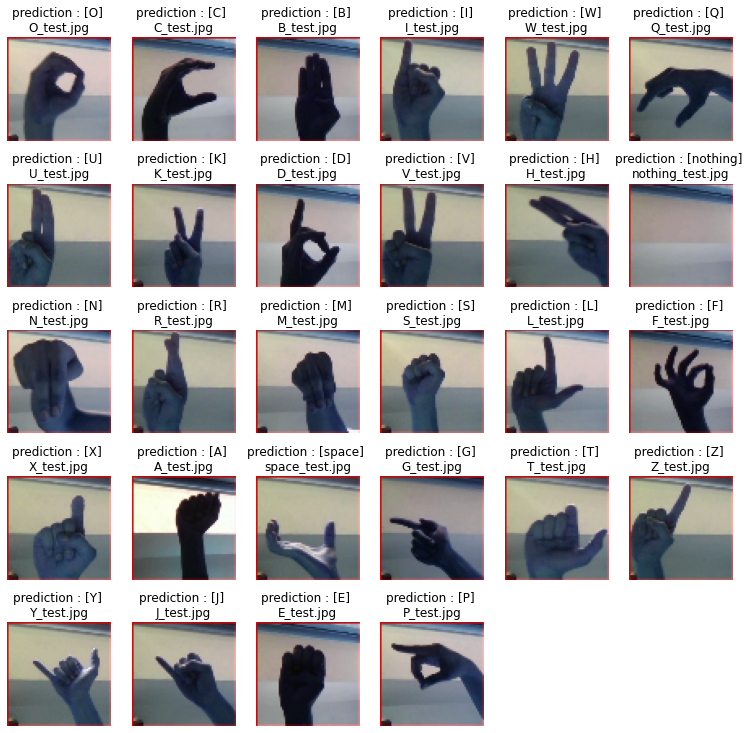

In [12]:
predfigure = plt.figure(figsize = (13,13))
def plot_image_1(fig, image, label, prediction, predictions_label, row, col, index):
    fig.add_subplot(row, col, index)
    plt.axis('off')
    plt.imshow(image)
    title = "prediction : [" + str(predictions_label) + "] "+ "\n" + label
    plt.title(title)
    return

image_index = 0
row = 5
col = 6
for i in range(1,(row*col-1)):
    plot_image_1(predfigure, test_images[image_index], test_img_names[image_index], predictions[image_index], predictions_labels_plot[image_index], row, col, i)
    image_index = image_index + 1
plt.show()

#### We observe are predictions are quite good. We get a very high mean test accuracy (99%+).
                            